# Coronavirus Topic Popularity

## Import required packages

In [ ]:
import numpy as np
import pandas as pd
import gensim
import nltk
nltk.download('wordnet')
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", palette="hsv")

from sklearn import linear_model
import statsmodels.api as sm

import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
np.random.seed(2020) # set seed for random generator

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset

In [ ]:
from google.colab import drive
drive.mount('drive') # mount drive on Colab so you can read files directly from your google drive

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/School/COMM 188/merged_tweetIDs.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/School/COMM 188/filtered_tweets.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Take the column with header "created_at" and "text". Here only english tweets are processed.



In [ ]:
# convert contents heading with 'created_at' in the dataset to the date format MM_DD
def date2MMDD(date):
  return date[4:10]
dataset['created_at'] = dataset['created_at'].map(date2MMDD)

In [ ]:
!pip install pyLDAvis
!pip install openpyxl

We are looking at all the Tweets from the time period February to April

In [ ]:
day_dict = {} # create a dictionary with each day as an independent key; e.g. "March 01" will be the key for March 1st
for i in range(1,10):
  day_dict[f'February 0{i}'] = dataset['text'][dataset['created_at'] == f'Feb 0{i}'][dataset['lang'] == 'en']
for i in range(10,29):
  day_dict[f'February {i}'] = dataset['text'][dataset['created_at'] == f'Feb {i}'][dataset['lang'] == 'en']

for i in range(1,10):
  day_dict[f'March 0{i}'] = dataset['text'][dataset['created_at'] == f'Mar 0{i}'][dataset['lang'] == 'en']
for i in range(10,32):
  day_dict[f'March {i}'] = dataset['text'][dataset['created_at'] == f'Mar {i}'][dataset['lang'] == 'en']

for i in range(1,10):
  day_dict[f'April 0{i}'] = dataset['text'][dataset['created_at'] == f'Apr 0{i}'][dataset['lang'] == 'en']
for i in range(10,11):
  day_dict[f'April {i}'] = dataset['text'][dataset['created_at'] == f'Apr {i}'][dataset['lang'] == 'en']


## Data Preprocessing

We will preprocess the text using the following few steps:

*   Tokenization: split sentences into words. Lowercase all letters and remove punctuations.
*   Words less than 3 characters are removed.
*   All stop words are removed.
*   Lemmatization: words in third person are changed to first person and verbs in past and future tenses are changed into present.
*   Stemming: words are reduced to their root form.



In [ ]:
stemmer = SnowballStemmer('english') # stemming for English texts

# Function to perform lemmatize and stem preprocessing steps on the data set.
def lemmatize_stemming(text): # lemmatization
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: # remove all stop words and discard words less than 3 chars
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
for key in day_dict.keys():
  day_dict[key] = day_dict[key].map(preprocess) # apply preprocess function to each tweet

## Keywords analysis

In [ ]:
# Bag of words from the preprocessed data
import itertools
dictionary = gensim.corpora.Dictionary(list(itertools.chain.from_iterable(day_dict.values())))

In [ ]:
# filter out tokens. Here we only keep the 20 most frequent tokens.
dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=20)

Display 20 most frequent keywords:

In [ ]:
for i, j in zip(dictionary.token2id.keys(), dictionary.dfs.values()):
  print (i,j)

corona 910
virus 1073
https 5124
china 5605
coronavirus 2314
wuhan 530
outbreak 602
health 546
case 898
know 497
peopl 1288
say 819
chines 533
spread 523
time 554
trump 970
like 711
pandem 626
test 684
covid 1908


In [ ]:
# bow for each day
bow_day = []
for doc in day_dict.values():
  bow_day.append(dictionary.doc2bow(list(itertools.chain.from_iterable(doc))))

## Topic modeling


Run topic modeling based on the collected information using LDA (Latent Dirichlet Allocation).

In [ ]:
dictionary_full = gensim.corpora.Dictionary(list(itertools.chain.from_iterable(day_dict.values())))
dictionary_full.filter_extremes(no_below=15, no_above=0.5, keep_n=1000) # retrieve 1000 keywords for topic modeling
bow_corpus = [dictionary_full.doc2bow(doc) for doc in list(itertools.chain.from_iterable(day_dict.values()))]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary_full, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.125*"https" + 0.060*"covid" + 0.053*"coronavirus" + 0.023*"go" + 0.010*"need" + 0.010*"help" + 0.009*"peopl" + 0.009*"spread" + 0.009*"take" + 0.009*"fuck"
Topic: 1 
Words: 0.059*"https" + 0.055*"coronavirus" + 0.033*"china" + 0.025*"chines" + 0.017*"lockdown" + 0.016*"die" + 0.013*"state" + 0.012*"doctor" + 0.011*"warn" + 0.010*"amid"
Topic: 2 
Words: 0.092*"coronavirus" + 0.047*"case" + 0.046*"https" + 0.034*"death" + 0.018*"report" + 0.017*"confirm" + 0.016*"health" + 0.015*"news" + 0.014*"world" + 0.014*"covid"
Topic: 3 
Words: 0.069*"https" + 0.046*"covid" + 0.028*"coronavirus" + 0.016*"video" + 0.016*"virus" + 0.015*"know" + 0.014*"think" + 0.013*"corona" + 0.011*"china" + 0.011*"tell"
Topic: 4 
Words: 0.025*"coronavirus" + 0.022*"vote" + 0.021*"right" + 0.017*"https" + 0.017*"help" + 0.015*"today" + 0.012*"donat" + 0.011*"china" + 0.010*"trump" + 0.010*"mean"
Topic: 5 
Words: 0.063*"covid" + 0.021*"need" + 0.020*"https" + 0.018*"peopl" + 0.013*"coronavirus" + 

In [ ]:

get_document_topics = lda_model.get_document_topics(bow_corpus[0])
print(get_document_topics)

[(0, 0.0142897), (1, 0.014286452), (2, 0.014286218), (3, 0.8714086), (4, 0.0142868785), (5, 0.01428743), (6, 0.014287), (7, 0.01428626), (8, 0.014290826), (9, 0.014290621)]


Finding the Dominant Topic for each individual Tweet

In [ ]:
def dominant_topic(lda_model, bow_corpus, texts):
     #Function to find the dominant topic in each Tweet
     sent_topics_df = pd.DataFrame()
     # Get main topic in each Tweet
     for i, row in enumerate(lda_model[bow_corpus]):
         row = sorted(row, key=lambda x: (x[1]), reverse=True)
         # Get the Dominant topic, Perc Contribution and Keywords for each Tweet
         for j, (topic_num, prop_topic) in enumerate(row):
             if j == 0:  # dominant topic
                 wp = lda_model.show_topic(topic_num)
                 topic_keywords = ", ".join([word for word, prop in wp])
                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
             else:
                 break
     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     contents = pd.Series(texts)
     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
     return(sent_topics_df)


In [ ]:
df_dominant_topic = dominant_topic(lda_model=lda_model, bow_corpus=bow_corpus, texts=dataset['text'])
df_dominant_topic

,Dominant_Topic,Perc_Contribution,Topic_Keywords,text
0,3.0,0.871409,"https, covid, coronavirus, video, virus, know,...","RT @DrGJackBrown: Tom Cotton — a U.S. Senator,..."
1,7.0,0.699953,"https, china, coronavirus, trump, pandem, peop...",RT @chayraestillore: this corona virus is givi...
2,4.0,0.374477,"coronavirus, vote, right, https, help, today, ...",RT @sweetkizzez504: Me after listening to @Fri...
3,3.0,0.456171,"https, covid, coronavirus, video, virus, know,...",Underrated tweet 🔥 https://t.co/5whhQq1zaD
4,0.0,0.762183,"https, covid, coronavirus, go, need, help, peo...",@sh_irredeemable @SenTomCotton If Nixon hadn’t...
...,...,...,...,...
17404,NaN,NaN,NaN,Stay home &amp; Contact us if you are looking ...
17405,NaN,NaN,NaN,RT @elfindonesiacom: Happy Birthday Eunhyuk!\n...
17406,NaN,NaN,NaN,RT @fred_guttenberg: Nice comments from @ewarr...
17407,NaN,NaN,NaN,@POTUS Please tell America that this Lizard Ki...


In [ ]:
writer = pd.ExcelWriter('output.xlsx')
df_dominant_topic.to_excel(writer)
writer.save()
print('DataFrame is written successfully to Excel File.')

DataFrame is written successfully to Excel File.


Here we export the DataFrame to Excel to continue our analysis in the Excel workbook


## LDA Analysis




In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.001683  0.122509       1        1  13.580841
7     -0.061889  0.001720       2        1  11.550728
1     -0.122549  0.086560       3        1  11.294103
9     -0.021260 -0.028223       4        1  10.781889
0      0.006003  0.021136       5        1  10.253177
8      0.146558  0.013172       6        1   9.722067
3      0.010656  0.016959       7        1   8.524715
6     -0.086023 -0.053068       8        1   8.519485
4     -0.011013 -0.190795       9        1   7.906927
5      0.141199  0.010030      10        1   7.866072, topic_info=       Term         Freq        Total Category  logprob  loglift
971   covid  2679.000000  2679.000000  Default  30.0000  30.0000
6     https  5604.000000  5604.000000  Default  29.0000  29.0000
177    stay   624.000000   624.000000  Default  28.0000  28.0000
40     case  1005.000000  1005.000000  Default  27.0000  27.0000
113    home   655.000000   655.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
240  pandem    64.121727   919.795288  Topic10  -4.9164  -0.1208
186   trump    61.714142  1104.811523  Topic10  -4.9546  -0.3423
518  social    52.086124   469.817902  Topic10  -5.1242   0.3432
91     work    51.865841   460.781464  Topic10  -5.1285   0.3583
1    corona    50.508194   796.599487  Topic10  -5.1550  -0.2156

[628 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
831       3  0.032278  access
831       4  0.016139  access
831       5  0.145252  access
831       6  0.048417  access
831       7  0.726258  access
...     ...       ...     ...
553       4  0.017737    zero
553       5  0.656261    zero
553       6  0.088684    zero
553       9  0.017737    zero
553      10  0.141894    zero

[3139 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 2, 10, 1, 9, 4, 7, 5, 6])

## Statistical Analysis + Modeling

Combinations of data plots of the dominant topics vs. favorites and retweets

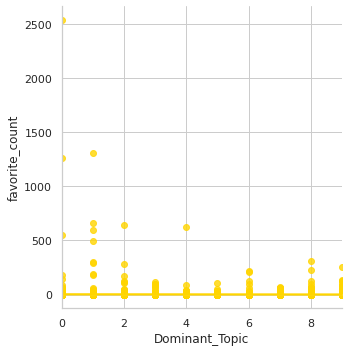

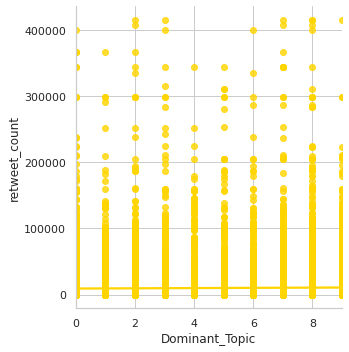

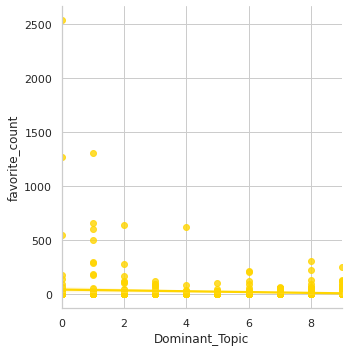

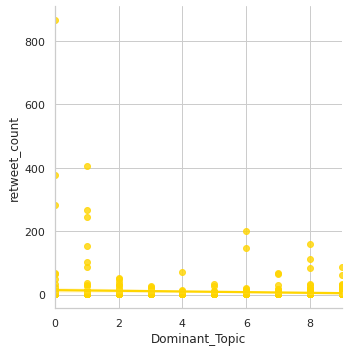

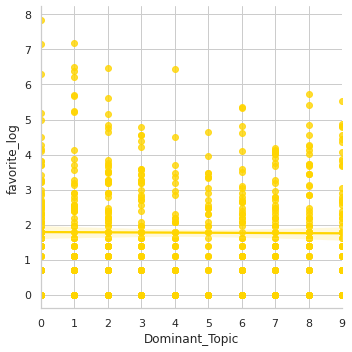

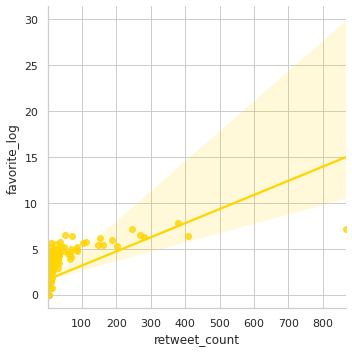

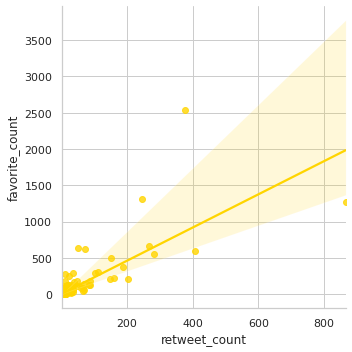

In [ ]:
sns.lmplot(x="Dominant_Topic",y="favorite_count",data=dataset)
sns.lmplot(x="Dominant_Topic",y="retweet_count",data=dataset)

sns.lmplot(x="Dominant_Topic",y="favorite_count",data=dataset2)
sns.lmplot(x="Dominant_Topic",y="retweet_count",data=dataset2)

sns.lmplot(x="Dominant_Topic",y="favorite_log",data=dataset2)
sns.lmplot(x="retweet_count",y="favorite_log",data=dataset2)

sns.lmplot(x="retweet_count",y="favorite_count",data=dataset2)


Non-transformed model regression

In [ ]:
new_df = pd.DataFrame({'favorite_count' : dataset['favorite_count'],'retweet_count' : dataset['retweet_count']})
fill_new_df = new_df.fillna(0)
fill_new_df['favorite_count'].astype('object')

drop_df = dataset.dropna()
drop_df['Dominant_Topic'].astype('object')
xvar = fill_new_df[['favorite_count','retweet_count']][0:17028]
y_df = dataset.dropna(subset=['Dominant_Topic'])
yvar = y_df['Dominant_Topic']


regr = linear_model.LinearRegression()
regr.fit(xvar,yvar)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

xvar = sm.add_constant(xvar) # adding a constant

model = sm.OLS(yvar, xvar).fit()
predictions = model.predict(xvar)

print_model = model.summary()
print(print_model)

Intercept: 
 4.312713178505365
Coefficients: 
 [-2.35584160e-03  1.49195034e-06]
                            OLS Regression Results                            
Dep. Variable:         Dominant_Topic   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.112
Date:                Mon, 01 Jun 2020   Prob (F-statistic):            0.00222
Time:                        05:16:29   Log-Likelihood:                -43180.
No. Observations:               17028   AIC:                         8.637e+04
Df Residuals:                   17025   BIC:                         8.639e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

Regression of the logarithmically transformed model

In [ ]:
new_df = pd.DataFrame({'favorite_log' : dataset2['favorite_log'],'retweet_log' : dataset2['retweet_log']})
x = new_df[['favorite_log','retweet_log']][0:719]
y = np.array(dataset2.Dominant_Topic.dropna())

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

xvar = sm.add_constant(x) # adding a constant

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)


Intercept: 
 4.123713312640334
Coefficients: 
 [-0.00242415 -0.02285343]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.387
Model:                            OLS   Adj. R-squared (uncentered):              0.385
Method:                 Least Squares   F-statistic:                              225.9
Date:                Mon, 01 Jun 2020   Prob (F-statistic):                    8.44e-77
Time:                        05:16:29   Log-Likelihood:                         -2016.6
No. Observations:                 719   AIC:                                      4037.
Df Residuals:                     717   BIC:                                      4046.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t  

## Alternate regressions and transforms

In [ ]:
pt = PowerTransformer()

dt_array = dataset['Dominant_Topic'].to_numpy()
fc_array = dataset['favorite_count'].to_numpy()

data = [dt_array]
print(pt.fit(data))
print(pt.lambdas_)
print(pt.transform(data))
pt_data = pt.transform(data)

data2 = [fc_array]
print(pt.fit(data2))
print(pt.lambdas_)
print(pt.transform(data2))
pt_data2 = pt.transform(data2)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: Degrees of freedom <= 0 for slice
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[8.47213581 8.47213581 8.47213581 ... 8.47213581 8.47213581 8.47213581]
[[ 0.  0.  0. ... nan nan nan]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[8.47213581 8.47213581 8.47213581 ... 8.47213581 8.47213581 8.47213581]
[[0. 0. 0. ... 0. 0. 0.]]
